In [1]:
from ast import dump
from paddleocr import PaddleOCR, draw_ocr
import os
from glob import glob
from tqdm import tqdm
import json
import cv2
from matplotlib import pyplot as plt

In [2]:
ocr = PaddleOCR(use_angle_cls=True, lang='ch')

[2022/06/17 14:30:56] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_fce_box_type='poly', det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='quad', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='f

In [3]:
def calc_single_image_ratio(boxes):
    if len(boxes) == 0:
        return -1
    
    ratio = 0
    for box in boxes:
        pos, text, _ = box
        x1, x2, x3, x4 = pos
        wide = x2[0] - x1[0]
        height = x3[1] - x2[1]
        if wide == 0.0:
            wide = 1
        if height == 0.0:
            height = 1
        tmp_ratio = wide / height
#         print(tmp_ratio)
        ratio += tmp_ratio
    
    average_ratio = ratio / len(boxes)
    
    return average_ratio

In [10]:
def rotate_detect_single_image(img_path):
#     print(img_path)
    img_cv = cv2.imread(img_path)
    img_np = np.array(img_cv)
    
    drt_dict = {}
    sum_conf, average_angle = 0, 0
    for i in range(4):
        img_np_i = np.rot90(img_np, i)
        boxes = ocr.ocr(img_np_i, cls=True)
        ratio = calc_single_image_ratio(boxes)
        sum_angle, sum_conf, average_angle = 0, 0, 0
        if len(boxes) != 0:
            for box in boxes:
                pos, text, angle = box
                sum_conf += text[1]
                sum_angle += int(angle[0])
            average_angle = sum_angle / len(boxes)
        drt_dict[i] = [sum_conf, ratio, average_angle]
    
    true_drt = -1
    max_conf = 0
    for drt, drt_info in drt_dict.items():
        sum_conf, ratio, average_angle = drt_info
        if ratio <= 0.5:
            continue
        if average_angle > 90:
            continue
        if sum_conf > max_conf:
            true_drt = drt
            max_conf = sum_conf
    
    return true_drt

In [11]:
img_path = "/root/QianZe/VizWiz-VQA-tiny/test_rectify"
ips = sorted(glob(os.path.join(img_path, "*")))
# print(ips[:10])
pred = {}

cnt = 0
for ip in tqdm(ips):
    img_name = ip.split("/")[-1].split(".")[0]
    max_drt = rotate_detect_single_image(ip)
    pred[img_name] = max_drt
    # if cnt <= 10:
    #     for line in result:
    #         print(line)
    cnt += 1

  0%|          | 0/100 [00:00<?, ?it/s]

[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03173494338989258
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 3, elapse : 0.004273891448974609
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 3, elapse : 0.007363319396972656
[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 3, elapse : 0.04279518127441406
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 3, elapse : 0.005570173263549805
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 3, elapse : 0.00828242301940918
[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03957080841064453
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 3, elapse : 0.004111051559448242
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 3, elapse : 0.007431507110595703
[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 3, elapse : 0.04250001907348633
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 3, elapse : 0.005063533782958984
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 3, elapse : 0.008122444152832031


  1%|          | 1/100 [00:00<00:34,  2.85it/s]

[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 25, elapse : 0.020806550979614258
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 25, elapse : 0.027010440826416016
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 25, elapse : 0.05457806587219238
[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 12, elapse : 0.01580953598022461
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 12, elapse : 0.010840892791748047
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 12, elapse : 0.0238192081451416
[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 24, elapse : 0.020720481872558594
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 24, elapse : 0.015428781509399414
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 24, elapse : 0.04941129684448242
[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 9, elapse : 0.015292644500732422
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 9, elapse : 0.010844945907592773
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 9, elapse : 0.016948461532592773


  2%|▏         | 2/100 [00:00<00:31,  3.10it/s]

[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 19, elapse : 0.038834571838378906
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 19, elapse : 0.024295568466186523
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 19, elapse : 0.04143881797790527
[2022/06/17 14:33:29] ppocr DEBUG: dt_boxes num : 20, elapse : 0.05222916603088379
[2022/06/17 14:33:29] ppocr DEBUG: cls num  : 20, elapse : 0.01957559585571289
[2022/06/17 14:33:29] ppocr DEBUG: rec_res num  : 20, elapse : 0.03953909873962402
[2022/06/17 14:33:30] ppocr DEBUG: dt_boxes num : 18, elapse : 0.04721784591674805
[2022/06/17 14:33:30] ppocr DEBUG: cls num  : 18, elapse : 0.01762247085571289
[2022/06/17 14:33:30] ppocr DEBUG: rec_res num  : 18, elapse : 0.03673744201660156
[2022/06/17 14:33:30] ppocr DEBUG: dt_boxes num : 19, elapse : 0.0522160530090332
[2022/06/17 14:33:30] ppocr DEBUG: cls num  : 19, elapse : 0.022477388381958008
[2022/06/17 14:33:30] ppocr DEBUG: rec_res num  : 19, elapse : 0.03945016860961914


  3%|▎         | 3/100 [00:01<00:44,  2.20it/s]

[2022/06/17 14:33:30] ppocr DEBUG: dt_boxes num : 6, elapse : 0.037528038024902344
[2022/06/17 14:33:30] ppocr DEBUG: cls num  : 6, elapse : 0.005107402801513672
[2022/06/17 14:33:30] ppocr DEBUG: rec_res num  : 6, elapse : 0.01773214340209961
[2022/06/17 14:33:30] ppocr DEBUG: dt_boxes num : 2, elapse : 0.039888858795166016
[2022/06/17 14:33:30] ppocr DEBUG: cls num  : 2, elapse : 0.008611679077148438
[2022/06/17 14:33:30] ppocr DEBUG: rec_res num  : 2, elapse : 0.005911827087402344
[2022/06/17 14:33:30] ppocr DEBUG: dt_boxes num : 2, elapse : 0.037345170974731445
[2022/06/17 14:33:30] ppocr DEBUG: cls num  : 2, elapse : 0.004225730895996094
[2022/06/17 14:33:30] ppocr DEBUG: rec_res num  : 2, elapse : 0.007608890533447266
[2022/06/17 14:33:30] ppocr DEBUG: dt_boxes num : 2, elapse : 0.03841972351074219
[2022/06/17 14:33:30] ppocr DEBUG: cls num  : 2, elapse : 0.008640766143798828
[2022/06/17 14:33:30] ppocr DEBUG: rec_res num  : 2, elapse : 0.009987354278564453


  4%|▍         | 4/100 [00:01<00:38,  2.48it/s]

[2022/06/17 14:33:30] ppocr DEBUG: dt_boxes num : 15, elapse : 0.039491891860961914
[2022/06/17 14:33:30] ppocr DEBUG: cls num  : 15, elapse : 0.015357494354248047
[2022/06/17 14:33:30] ppocr DEBUG: rec_res num  : 15, elapse : 0.026936769485473633
[2022/06/17 14:33:30] ppocr DEBUG: dt_boxes num : 11, elapse : 0.04706096649169922
[2022/06/17 14:33:30] ppocr DEBUG: cls num  : 11, elapse : 0.012821674346923828
[2022/06/17 14:33:30] ppocr DEBUG: rec_res num  : 11, elapse : 0.025691747665405273
[2022/06/17 14:33:30] ppocr DEBUG: dt_boxes num : 13, elapse : 0.047154903411865234
[2022/06/17 14:33:30] ppocr DEBUG: cls num  : 13, elapse : 0.014285802841186523
[2022/06/17 14:33:30] ppocr DEBUG: rec_res num  : 13, elapse : 0.023949861526489258
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 10, elapse : 0.04665851593017578
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 10, elapse : 0.009293556213378906
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 10, elapse : 0.023617982864379883


  5%|▌         | 5/100 [00:02<00:41,  2.28it/s]

[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 6, elapse : 0.013354301452636719
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 6, elapse : 0.004724740982055664
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 6, elapse : 0.012226343154907227
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 2, elapse : 0.012118816375732422
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 2, elapse : 0.006203651428222656
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 2, elapse : 0.005456447601318359
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 6, elapse : 0.013211727142333984
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 6, elapse : 0.004456996917724609
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 6, elapse : 0.01154184341430664
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 1, elapse : 0.011434555053710938
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 1, elapse : 0.0039825439453125
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 1, elapse : 0.0043582916259765625


  6%|▌         | 6/100 [00:02<00:31,  3.01it/s]

[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03408956527709961
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 3, elapse : 0.004959821701049805
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 3, elapse : 0.007872581481933594
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04086017608642578
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 6, elapse : 0.004578351974487305
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 6, elapse : 0.012350082397460938
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 2, elapse : 0.039072513580322266
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 2, elapse : 0.0046541690826416016
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 2, elapse : 0.0068171024322509766
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 8, elapse : 0.042066335678100586
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 8, elapse : 0.007295370101928711
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 8, elapse : 0.016257286071777344


  7%|▋         | 7/100 [00:02<00:30,  3.07it/s]

[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 7, elapse : 0.03461027145385742
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 7, elapse : 0.009237527847290039
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 7, elapse : 0.014771461486816406
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 10, elapse : 0.0471501350402832
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 10, elapse : 0.010607242584228516
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 10, elapse : 0.023435115814208984
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 9, elapse : 0.04341387748718262
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 9, elapse : 0.009128093719482422
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 9, elapse : 0.018755674362182617
[2022/06/17 14:33:31] ppocr DEBUG: dt_boxes num : 11, elapse : 0.0459284782409668
[2022/06/17 14:33:31] ppocr DEBUG: cls num  : 11, elapse : 0.010713815689086914
[2022/06/17 14:33:31] ppocr DEBUG: rec_res num  : 11, elapse : 0.026007890701293945


  8%|▊         | 8/100 [00:02<00:33,  2.77it/s]

[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 8, elapse : 0.033170461654663086
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 8, elapse : 0.008269309997558594
[2022/06/17 14:33:32] ppocr DEBUG: rec_res num  : 8, elapse : 0.01633143424987793
[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 7, elapse : 0.04444313049316406
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 7, elapse : 0.01043248176574707
[2022/06/17 14:33:32] ppocr DEBUG: rec_res num  : 7, elapse : 0.014724969863891602
[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 9, elapse : 0.043073415756225586
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 9, elapse : 0.008738517761230469
[2022/06/17 14:33:32] ppocr DEBUG: rec_res num  : 9, elapse : 0.01740431785583496
[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 8, elapse : 0.044614553451538086
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 8, elapse : 0.014547348022460938
[2022/06/17 14:33:32] ppocr DEBUG: rec_res num  : 8, elapse : 0.01914501190185547


  9%|▉         | 9/100 [00:03<00:35,  2.58it/s]

[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 8, elapse : 0.03457307815551758
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 8, elapse : 0.0072290897369384766
[2022/06/17 14:33:32] ppocr DEBUG: rec_res num  : 8, elapse : 0.01533961296081543
[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04597878456115723
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 5, elapse : 0.00508427619934082
[2022/06/17 14:33:32] ppocr DEBUG: rec_res num  : 5, elapse : 0.009490013122558594
[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 8, elapse : 0.04410862922668457
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 8, elapse : 0.007447242736816406
[2022/06/17 14:33:32] ppocr DEBUG: rec_res num  : 8, elapse : 0.015909910202026367
[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04690265655517578
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 6, elapse : 0.005483150482177734
[2022/06/17 14:33:32] ppocr DEBUG: rec_res num  : 6, elapse : 0.011588573455810547


 10%|█         | 10/100 [00:03<00:35,  2.51it/s]

[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 9, elapse : 0.03672075271606445
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 9, elapse : 0.008025884628295898
[2022/06/17 14:33:32] ppocr DEBUG: rec_res num  : 9, elapse : 0.01748037338256836
[2022/06/17 14:33:32] ppocr DEBUG: dt_boxes num : 7, elapse : 0.04248857498168945
[2022/06/17 14:33:32] ppocr DEBUG: cls num  : 7, elapse : 0.008864641189575195
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 7, elapse : 0.014389276504516602
[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 5, elapse : 0.0371248722076416
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 5, elapse : 0.004609823226928711
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 5, elapse : 0.009007930755615234
[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03821587562561035
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 4, elapse : 0.0041310787200927734
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 4, elapse : 0.008154630661010742


 11%|█         | 11/100 [00:04<00:32,  2.72it/s]

[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 10, elapse : 0.03441786766052246
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 10, elapse : 0.008150815963745117
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 10, elapse : 0.027779579162597656
[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 8, elapse : 0.045276641845703125
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 8, elapse : 0.008838891983032227
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 8, elapse : 0.023769855499267578
[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 10, elapse : 0.043181419372558594
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 10, elapse : 0.009132623672485352
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 10, elapse : 0.026793241500854492
[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 8, elapse : 0.045287132263183594
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 8, elapse : 0.00919032096862793
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 8, elapse : 0.026465177536010742


 12%|█▏        | 12/100 [00:04<00:35,  2.48it/s]

[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 4, elapse : 0.031305551528930664
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 4, elapse : 0.005076408386230469
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 4, elapse : 0.009845256805419922
[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 3, elapse : 0.04395461082458496
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 3, elapse : 0.005166053771972656
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 3, elapse : 0.008381843566894531
[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 4, elapse : 0.04031538963317871
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 4, elapse : 0.00506901741027832
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 4, elapse : 0.010728597640991211
[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 2, elapse : 0.042754173278808594
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 2, elapse : 0.004827976226806641
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 2, elapse : 0.00636601448059082


 13%|█▎        | 13/100 [00:04<00:33,  2.60it/s]

[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 0, elapse : 0.00904536247253418
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 0, elapse : 0
[2022/06/17 14:33:33] ppocr DEBUG: rec_res num  : 0, elapse : 1.430511474609375e-06
[2022/06/17 14:33:33] ppocr DEBUG: dt_boxes num : 2, elapse : 0.011674642562866211
[2022/06/17 14:33:33] ppocr DEBUG: cls num  : 2, elapse : 0.003900289535522461
[2022/06/17 14:33:34] ppocr DEBUG: rec_res num  : 2, elapse : 0.005962371826171875
[2022/06/17 14:33:34] ppocr DEBUG: dt_boxes num : 0, elapse : 0.009202718734741211
[2022/06/17 14:33:34] ppocr DEBUG: cls num  : 0, elapse : 0
[2022/06/17 14:33:34] ppocr DEBUG: rec_res num  : 0, elapse : 1.6689300537109375e-06
[2022/06/17 14:33:34] ppocr DEBUG: dt_boxes num : 2, elapse : 0.011143684387207031
[2022/06/17 14:33:34] ppocr DEBUG: cls num  : 2, elapse : 0.003604888916015625
[2022/06/17 14:33:34] ppocr DEBUG: rec_res num  : 2, elapse : 0.005850076675415039
[2022/06/17 14:33:34] ppocr DEBUG: dt_boxes num : 7, ela

 15%|█▌        | 15/100 [00:05<00:27,  3.11it/s]

[2022/06/17 14:33:34] ppocr DEBUG: dt_boxes num : 9, elapse : 0.0385279655456543
[2022/06/17 14:33:34] ppocr DEBUG: cls num  : 9, elapse : 0.008609771728515625
[2022/06/17 14:33:34] ppocr DEBUG: rec_res num  : 9, elapse : 0.020767927169799805
[2022/06/17 14:33:34] ppocr DEBUG: dt_boxes num : 6, elapse : 0.040326595306396484
[2022/06/17 14:33:34] ppocr DEBUG: cls num  : 6, elapse : 0.005370140075683594
[2022/06/17 14:33:34] ppocr DEBUG: rec_res num  : 6, elapse : 0.010828256607055664
[2022/06/17 14:33:34] ppocr DEBUG: dt_boxes num : 8, elapse : 0.04002785682678223
[2022/06/17 14:33:34] ppocr DEBUG: cls num  : 8, elapse : 0.007812023162841797
[2022/06/17 14:33:34] ppocr DEBUG: rec_res num  : 8, elapse : 0.018058300018310547
[2022/06/17 14:33:34] ppocr DEBUG: dt_boxes num : 6, elapse : 0.03999209403991699
[2022/06/17 14:33:34] ppocr DEBUG: cls num  : 6, elapse : 0.006282806396484375
[2022/06/17 14:33:34] ppocr DEBUG: rec_res num  : 6, elapse : 0.011932849884033203


 16%|█▌        | 16/100 [00:05<00:27,  3.03it/s]

[2022/06/17 14:33:34] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03429746627807617
[2022/06/17 14:33:34] ppocr DEBUG: cls num  : 3, elapse : 0.004176616668701172
[2022/06/17 14:33:34] ppocr DEBUG: rec_res num  : 3, elapse : 0.00743412971496582
[2022/06/17 14:33:34] ppocr DEBUG: dt_boxes num : 3, elapse : 0.041150569915771484
[2022/06/17 14:33:34] ppocr DEBUG: cls num  : 3, elapse : 0.003903627395629883
[2022/06/17 14:33:34] ppocr DEBUG: rec_res num  : 3, elapse : 0.007050275802612305
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 3, elapse : 0.04042458534240723
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 3, elapse : 0.003923177719116211
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 3, elapse : 0.00705718994140625
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 3, elapse : 0.038501739501953125
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 3, elapse : 0.003916263580322266
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 3, elapse : 0.006916046142578125


 17%|█▋        | 17/100 [00:06<00:26,  3.11it/s]

[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 8, elapse : 0.03391861915588379
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 8, elapse : 0.007938623428344727
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 8, elapse : 0.01647806167602539
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 2, elapse : 0.03768181800842285
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 2, elapse : 0.0038170814514160156
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 2, elapse : 0.006087303161621094
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 8, elapse : 0.03838610649108887
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 8, elapse : 0.008041620254516602
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 8, elapse : 0.01615309715270996
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 2, elapse : 0.03706550598144531
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 2, elapse : 0.0037546157836914062
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 2, elapse : 0.006013631820678711


 18%|█▊        | 18/100 [00:06<00:26,  3.14it/s]

[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 6, elapse : 0.013107538223266602
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 6, elapse : 0.004627704620361328
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 6, elapse : 0.010595321655273438
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 3, elapse : 0.012269735336303711
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 3, elapse : 0.003602743148803711
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 3, elapse : 0.007264614105224609
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 5, elapse : 0.012329816818237305
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 5, elapse : 0.0033791065216064453
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 5, elapse : 0.009046316146850586
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 2, elapse : 0.011947870254516602
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 2, elapse : 0.0041272640228271484
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 2, elapse : 0.005379676818847656


 19%|█▉        | 19/100 [00:06<00:21,  3.81it/s]

[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 8, elapse : 0.012815713882446289
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 8, elapse : 0.006754636764526367
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 8, elapse : 0.025697708129882812
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 6, elapse : 0.01312398910522461
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 6, elapse : 0.005072593688964844
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 6, elapse : 0.020399808883666992
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 9, elapse : 0.014264822006225586
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 9, elapse : 0.008820056915283203
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 9, elapse : 0.02292037010192871
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 6, elapse : 0.013017892837524414
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 6, elapse : 0.00513005256652832
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 6, elapse : 0.018326759338378906


 20%|██        | 20/100 [00:06<00:19,  4.13it/s]

[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 11, elapse : 0.03711533546447754
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 11, elapse : 0.012071371078491211
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 11, elapse : 0.028214454650878906
[2022/06/17 14:33:35] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04511451721191406
[2022/06/17 14:33:35] ppocr DEBUG: cls num  : 6, elapse : 0.00573277473449707
[2022/06/17 14:33:35] ppocr DEBUG: rec_res num  : 6, elapse : 0.0177152156829834
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 9, elapse : 0.04510331153869629
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 9, elapse : 0.009013652801513672
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 9, elapse : 0.02239251136779785
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 8, elapse : 0.047286033630371094
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 8, elapse : 0.008468389511108398
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 8, elapse : 0.01717996597290039


 21%|██        | 21/100 [00:07<00:24,  3.28it/s]

[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 5, elapse : 0.017977476119995117
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 5, elapse : 0.0044252872467041016
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 5, elapse : 0.009221792221069336
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 7, elapse : 0.01947021484375
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 7, elapse : 0.007090568542480469
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 7, elapse : 0.014619827270507812
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 8, elapse : 0.01966238021850586
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 8, elapse : 0.007668733596801758
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 8, elapse : 0.015455961227416992
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 7, elapse : 0.01936173439025879
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 7, elapse : 0.0070953369140625
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 7, elapse : 0.014823436737060547


 22%|██▏       | 22/100 [00:07<00:21,  3.69it/s]

[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 6, elapse : 0.01835322380065918
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 6, elapse : 0.004975557327270508
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 6, elapse : 0.0291595458984375
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 4, elapse : 0.019159793853759766
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 4, elapse : 0.005497455596923828
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 4, elapse : 0.019719362258911133
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 4, elapse : 0.01800084114074707
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 4, elapse : 0.003361225128173828
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 4, elapse : 0.01781773567199707
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 7, elapse : 0.01965188980102539
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 7, elapse : 0.006520271301269531
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 7, elapse : 0.0188143253326416


 23%|██▎       | 23/100 [00:07<00:19,  3.91it/s]

[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 8, elapse : 0.034665584564208984
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 8, elapse : 0.009671688079833984
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 8, elapse : 0.018769025802612305
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 10, elapse : 0.042119503021240234
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 10, elapse : 0.006524801254272461
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 10, elapse : 0.0285031795501709
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 9, elapse : 0.04387712478637695
[2022/06/17 14:33:36] ppocr DEBUG: cls num  : 9, elapse : 0.008389711380004883
[2022/06/17 14:33:36] ppocr DEBUG: rec_res num  : 9, elapse : 0.02070331573486328
[2022/06/17 14:33:36] ppocr DEBUG: dt_boxes num : 9, elapse : 0.0421597957611084
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 9, elapse : 0.00852823257446289
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 9, elapse : 0.028171777725219727


 24%|██▍       | 24/100 [00:08<00:23,  3.23it/s]

[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03374505043029785
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 5, elapse : 0.004494905471801758
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 5, elapse : 0.009865522384643555
[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 7, elapse : 0.0452878475189209
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 7, elapse : 0.007398366928100586
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 7, elapse : 0.014617443084716797
[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04492616653442383
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 5, elapse : 0.00400233268737793
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 5, elapse : 0.009067773818969727
[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 7, elapse : 0.04507279396057129
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 7, elapse : 0.006966590881347656
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 7, elapse : 0.013901948928833008


 25%|██▌       | 25/100 [00:08<00:25,  3.00it/s]

[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 1, elapse : 0.030954360961914062
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 1, elapse : 0.0032300949096679688
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 1, elapse : 0.004188060760498047
[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 4, elapse : 0.04247331619262695
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 4, elapse : 0.0036573410034179688
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 4, elapse : 0.014235734939575195
[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 2, elapse : 0.04047799110412598
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 2, elapse : 0.003068685531616211
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 2, elapse : 0.006676197052001953
[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04295969009399414
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 6, elapse : 0.0036089420318603516
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 6, elapse : 0.01746392250061035


 26%|██▌       | 26/100 [00:08<00:25,  2.96it/s]

[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 1, elapse : 0.009328842163085938
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 1, elapse : 0.0027871131896972656
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 1, elapse : 0.004769086837768555
[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 1, elapse : 0.009680509567260742
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 1, elapse : 0.003608226776123047
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 1, elapse : 0.0035026073455810547
[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 1, elapse : 0.009495258331298828
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 1, elapse : 0.0024487972259521484
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 1, elapse : 0.0034286975860595703
[2022/06/17 14:33:37] ppocr DEBUG: dt_boxes num : 1, elapse : 0.011761665344238281
[2022/06/17 14:33:37] ppocr DEBUG: cls num  : 1, elapse : 0.002681255340576172
[2022/06/17 14:33:37] ppocr DEBUG: rec_res num  : 1, elapse : 0.0036208629608154297
[2022/06/17 14:

 28%|██▊       | 28/100 [00:09<00:26,  2.75it/s]

[2022/06/17 14:33:38] ppocr DEBUG: dt_boxes num : 14, elapse : 0.04269528388977051
[2022/06/17 14:33:38] ppocr DEBUG: cls num  : 14, elapse : 0.010396480560302734
[2022/06/17 14:33:38] ppocr DEBUG: rec_res num  : 14, elapse : 0.03751778602600098
[2022/06/17 14:33:38] ppocr DEBUG: dt_boxes num : 10, elapse : 0.044914960861206055
[2022/06/17 14:33:38] ppocr DEBUG: cls num  : 10, elapse : 0.006905794143676758
[2022/06/17 14:33:38] ppocr DEBUG: rec_res num  : 10, elapse : 0.02118992805480957
[2022/06/17 14:33:38] ppocr DEBUG: dt_boxes num : 13, elapse : 0.044120073318481445
[2022/06/17 14:33:38] ppocr DEBUG: cls num  : 13, elapse : 0.010793685913085938
[2022/06/17 14:33:38] ppocr DEBUG: rec_res num  : 13, elapse : 0.03432202339172363
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 8, elapse : 0.043987274169921875
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 8, elapse : 0.007657527923583984
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 8, elapse : 0.015538215637207031


 29%|██▉       | 29/100 [00:10<00:27,  2.56it/s]

[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03049468994140625
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 5, elapse : 0.0037631988525390625
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 5, elapse : 0.012712717056274414
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 4, elapse : 0.04182004928588867
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 4, elapse : 0.003828287124633789
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 4, elapse : 0.00915837287902832
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03900027275085449
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 5, elapse : 0.003376483917236328
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 5, elapse : 0.012845277786254883
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04100513458251953
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 5, elapse : 0.00394439697265625
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 5, elapse : 0.011394262313842773


 30%|███       | 30/100 [00:10<00:26,  2.64it/s]

[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 5, elapse : 0.011397123336791992
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 5, elapse : 0.0035681724548339844
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 5, elapse : 0.008916139602661133
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 3, elapse : 0.010532855987548828
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 3, elapse : 0.0031130313873291016
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 3, elapse : 0.006850481033325195
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 5, elapse : 0.011351346969604492
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 5, elapse : 0.003295421600341797
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 5, elapse : 0.008725404739379883
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 2, elapse : 0.009856700897216797
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 2, elapse : 0.0029363632202148438
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 2, elapse : 0.00543665885925293


 31%|███       | 31/100 [00:10<00:21,  3.29it/s]

[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 1, elapse : 0.028725385665893555
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 1, elapse : 0.002763032913208008
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 1, elapse : 0.0037200450897216797
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 2, elapse : 0.035727500915527344
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 2, elapse : 0.0036013126373291016
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 2, elapse : 0.0060961246490478516
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 2, elapse : 0.035105228424072266
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 2, elapse : 0.0029277801513671875
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 2, elapse : 0.0054781436920166016
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 1, elapse : 0.03538775444030762
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 1, elapse : 0.003173828125
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 1, elapse : 0.00393223762512207


 32%|███▏      | 32/100 [00:10<00:19,  3.44it/s]

[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 4, elapse : 0.0308990478515625
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 4, elapse : 0.004495859146118164
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 4, elapse : 0.008823156356811523
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04188394546508789
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 5, elapse : 0.004036426544189453
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 5, elapse : 0.009218215942382812
[2022/06/17 14:33:39] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03998613357543945
[2022/06/17 14:33:39] ppocr DEBUG: cls num  : 5, elapse : 0.004205226898193359
[2022/06/17 14:33:39] ppocr DEBUG: rec_res num  : 5, elapse : 0.009518623352050781
[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 3, elapse : 0.04111075401306152
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 3, elapse : 0.0036880970001220703
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 3, elapse : 0.007239103317260742


 33%|███▎      | 33/100 [00:11<00:20,  3.29it/s]

[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 5, elapse : 0.031197786331176758
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 5, elapse : 0.004251241683959961
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 5, elapse : 0.009726285934448242
[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03345298767089844
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 4, elapse : 0.00315093994140625
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 4, elapse : 0.00788736343383789
[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03413891792297363
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 5, elapse : 0.0042002201080322266
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 5, elapse : 0.008994102478027344
[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03343915939331055
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 4, elapse : 0.0031278133392333984
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 4, elapse : 0.007834196090698242


 34%|███▍      | 34/100 [00:11<00:19,  3.45it/s]

[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03043842315673828
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 4, elapse : 0.003715991973876953
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 4, elapse : 0.007947206497192383
[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 4, elapse : 0.04065990447998047
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 4, elapse : 0.003155231475830078
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 4, elapse : 0.007757663726806641
[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 3, elapse : 0.038630008697509766
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 3, elapse : 0.00406336784362793
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 3, elapse : 0.007626771926879883
[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 3, elapse : 0.040130615234375
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 3, elapse : 0.003055572509765625
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 3, elapse : 0.006670475006103516


 35%|███▌      | 35/100 [00:11<00:19,  3.32it/s]

[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 6, elapse : 0.03119492530822754
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 6, elapse : 0.003988742828369141
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 6, elapse : 0.01202249526977539
[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04252362251281738
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 6, elapse : 0.005168914794921875
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 6, elapse : 0.010987997055053711
[2022/06/17 14:33:40] ppocr DEBUG: dt_boxes num : 6, elapse : 0.040105581283569336
[2022/06/17 14:33:40] ppocr DEBUG: cls num  : 6, elapse : 0.0035698413848876953
[2022/06/17 14:33:40] ppocr DEBUG: rec_res num  : 6, elapse : 0.012603044509887695
[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 4, elapse : 0.0476679801940918
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 4, elapse : 0.005161762237548828
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 4, elapse : 0.008732318878173828


 36%|███▌      | 36/100 [00:12<00:20,  3.08it/s]

[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 12, elapse : 0.03807950019836426
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 12, elapse : 0.007872581481933594
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 12, elapse : 0.020686864852905273
[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 17, elapse : 0.04273700714111328
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 17, elapse : 0.01029348373413086
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 17, elapse : 0.02861309051513672
[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 15, elapse : 0.041268348693847656
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 15, elapse : 0.010249614715576172
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 15, elapse : 0.026834964752197266
[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 18, elapse : 0.04365086555480957
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 18, elapse : 0.010260820388793945
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 18, elapse : 0.02982330322265625


 37%|███▋      | 37/100 [00:12<00:22,  2.86it/s]

[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 6, elapse : 0.03125119209289551
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 6, elapse : 0.0034914016723632812
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 6, elapse : 0.010331869125366211
[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04207801818847656
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 6, elapse : 0.004836082458496094
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 6, elapse : 0.011551856994628906
[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03940582275390625
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 5, elapse : 0.003413677215576172
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 5, elapse : 0.008667707443237305
[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04190397262573242
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 6, elapse : 0.004915952682495117
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 6, elapse : 0.010404586791992188


 38%|███▊      | 38/100 [00:12<00:22,  2.80it/s]

[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 7, elapse : 0.032271623611450195
[2022/06/17 14:33:41] ppocr DEBUG: cls num  : 7, elapse : 0.006151437759399414
[2022/06/17 14:33:41] ppocr DEBUG: rec_res num  : 7, elapse : 0.015160322189331055
[2022/06/17 14:33:41] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04356741905212402
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 6, elapse : 0.00627899169921875
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 6, elapse : 0.015408515930175781
[2022/06/17 14:33:42] ppocr DEBUG: dt_boxes num : 7, elapse : 0.04129910469055176
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 7, elapse : 0.006805419921875
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 7, elapse : 0.015798091888427734
[2022/06/17 14:33:42] ppocr DEBUG: dt_boxes num : 6, elapse : 0.046332359313964844
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 6, elapse : 0.005608081817626953
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 6, elapse : 0.01372671127319336


 39%|███▉      | 39/100 [00:13<00:22,  2.68it/s]

[2022/06/17 14:33:42] ppocr DEBUG: dt_boxes num : 7, elapse : 0.03144979476928711
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 7, elapse : 0.006654024124145508
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 7, elapse : 0.01399993896484375
[2022/06/17 14:33:42] ppocr DEBUG: dt_boxes num : 6, elapse : 0.037732839584350586
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 6, elapse : 0.0040400028228759766
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 6, elapse : 0.01086568832397461
[2022/06/17 14:33:42] ppocr DEBUG: dt_boxes num : 7, elapse : 0.036658525466918945
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 7, elapse : 0.006628513336181641
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 7, elapse : 0.014056205749511719
[2022/06/17 14:33:42] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03696489334106445
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 5, elapse : 0.0038290023803710938
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 5, elapse : 0.009527206420898438


 40%|████      | 40/100 [00:13<00:21,  2.85it/s]

[2022/06/17 14:33:42] ppocr DEBUG: dt_boxes num : 13, elapse : 0.03520369529724121
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 13, elapse : 0.010562896728515625
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 13, elapse : 0.06998014450073242
[2022/06/17 14:33:42] ppocr DEBUG: dt_boxes num : 11, elapse : 0.04524827003479004
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 11, elapse : 0.010650873184204102
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 11, elapse : 0.04935455322265625
[2022/06/17 14:33:42] ppocr DEBUG: dt_boxes num : 13, elapse : 0.04455280303955078
[2022/06/17 14:33:42] ppocr DEBUG: cls num  : 13, elapse : 0.01036381721496582
[2022/06/17 14:33:42] ppocr DEBUG: rec_res num  : 13, elapse : 0.05396127700805664
[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 12, elapse : 0.04973959922790527
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 12, elapse : 0.008197307586669922
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 12, elapse : 0.07701730728149414


 41%|████      | 41/100 [00:14<00:25,  2.29it/s]

[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 4, elapse : 0.034766197204589844
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 4, elapse : 0.007895708084106445
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 4, elapse : 0.0088653564453125
[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 5, elapse : 0.038037776947021484
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 5, elapse : 0.005259275436401367
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 5, elapse : 0.011359453201293945
[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 4, elapse : 0.037781476974487305
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 4, elapse : 0.00535273551940918
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 4, elapse : 0.008452177047729492
[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 4, elapse : 0.0377047061920166
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 4, elapse : 0.005861520767211914
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 4, elapse : 0.008455753326416016


 42%|████▏     | 42/100 [00:14<00:22,  2.58it/s]

[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 6, elapse : 0.03427886962890625
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 6, elapse : 0.00504755973815918
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 6, elapse : 0.021196365356445312
[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 4, elapse : 0.0459439754486084
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 4, elapse : 0.00552058219909668
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 4, elapse : 0.01265573501586914
[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04359602928161621
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 6, elapse : 0.005692243576049805
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 6, elapse : 0.022629737854003906
[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 7, elapse : 0.047773122787475586
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 7, elapse : 0.008981704711914062
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 7, elapse : 0.015554428100585938


 43%|████▎     | 43/100 [00:14<00:22,  2.49it/s]

[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 7, elapse : 0.020680904388427734
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 7, elapse : 0.008363485336303711
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 7, elapse : 0.01533651351928711
[2022/06/17 14:33:43] ppocr DEBUG: dt_boxes num : 9, elapse : 0.023929834365844727
[2022/06/17 14:33:43] ppocr DEBUG: cls num  : 9, elapse : 0.008016109466552734
[2022/06/17 14:33:43] ppocr DEBUG: rec_res num  : 9, elapse : 0.016992568969726562
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 12, elapse : 0.022965192794799805
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 12, elapse : 0.007975578308105469
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 12, elapse : 0.02089548110961914
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 11, elapse : 0.02377486228942871
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 11, elapse : 0.00861048698425293
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 11, elapse : 0.01934218406677246


 44%|████▍     | 44/100 [00:15<00:19,  2.86it/s]

[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 4, elapse : 0.033312082290649414
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 4, elapse : 0.0053844451904296875
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 4, elapse : 0.00885319709777832
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 5, elapse : 0.045218706130981445
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 5, elapse : 0.004315376281738281
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 5, elapse : 0.009176015853881836
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 3, elapse : 0.041452884674072266
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 3, elapse : 0.004523038864135742
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 3, elapse : 0.007296085357666016
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04579806327819824
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 6, elapse : 0.00464177131652832
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 6, elapse : 0.010337352752685547


 45%|████▌     | 45/100 [00:15<00:19,  2.78it/s]

[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 1, elapse : 0.03061532974243164
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 1, elapse : 0.0035457611083984375
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 1, elapse : 0.004706382751464844
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 1, elapse : 0.04211783409118652
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 1, elapse : 0.004348278045654297
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 1, elapse : 0.004671573638916016
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 1, elapse : 0.03923153877258301
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 1, elapse : 0.0038487911224365234
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 1, elapse : 0.004698753356933594
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 1, elapse : 0.042087554931640625
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 1, elapse : 0.004323482513427734
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 1, elapse : 0.005444765090942383


 46%|████▌     | 46/100 [00:15<00:18,  2.86it/s]

[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 5, elapse : 0.01202249526977539
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 5, elapse : 0.004920244216918945
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 5, elapse : 0.0106353759765625
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 4, elapse : 0.011904478073120117
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 4, elapse : 0.004497051239013672
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 4, elapse : 0.008331775665283203
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 5, elapse : 0.012059688568115234
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 5, elapse : 0.003907442092895508
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 5, elapse : 0.009609222412109375
[2022/06/17 14:33:44] ppocr DEBUG: dt_boxes num : 3, elapse : 0.010960578918457031
[2022/06/17 14:33:44] ppocr DEBUG: cls num  : 3, elapse : 0.003530263900756836
[2022/06/17 14:33:44] ppocr DEBUG: rec_res num  : 3, elapse : 0.00740504264831543


 47%|████▋     | 47/100 [00:15<00:14,  3.56it/s]

[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 1, elapse : 0.029812335968017578
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 1, elapse : 0.0038328170776367188
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 1, elapse : 0.009006500244140625
[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 1, elapse : 0.047399044036865234
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 1, elapse : 0.003737211227416992
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 1, elapse : 0.004573822021484375
[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 1, elapse : 0.03923344612121582
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 1, elapse : 0.004312753677368164
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 1, elapse : 0.005194187164306641
[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 1, elapse : 0.04623222351074219
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 1, elapse : 0.004171848297119141
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 1, elapse : 0.0049419403076171875


 48%|████▊     | 48/100 [00:16<00:15,  3.37it/s]

[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03169131278991699
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 3, elapse : 0.0051081180572509766
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 3, elapse : 0.007933378219604492
[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 9, elapse : 0.04699420928955078
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 9, elapse : 0.008743762969970703
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 9, elapse : 0.021284103393554688
[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 3, elapse : 0.04103827476501465
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 3, elapse : 0.005446195602416992
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 3, elapse : 0.006747722625732422
[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 9, elapse : 0.046573638916015625
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 9, elapse : 0.00818014144897461
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 9, elapse : 0.023014545440673828


 49%|████▉     | 49/100 [00:16<00:16,  3.03it/s]

[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 12, elapse : 0.036040306091308594
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 12, elapse : 0.009211063385009766
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 12, elapse : 0.02020406723022461
[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 9, elapse : 0.04721188545227051
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 9, elapse : 0.008398771286010742
[2022/06/17 14:33:45] ppocr DEBUG: rec_res num  : 9, elapse : 0.01654505729675293
[2022/06/17 14:33:45] ppocr DEBUG: dt_boxes num : 10, elapse : 0.04487943649291992
[2022/06/17 14:33:45] ppocr DEBUG: cls num  : 10, elapse : 0.008419275283813477
[2022/06/17 14:33:46] ppocr DEBUG: rec_res num  : 10, elapse : 0.017920494079589844
[2022/06/17 14:33:46] ppocr DEBUG: dt_boxes num : 7, elapse : 0.04881477355957031
[2022/06/17 14:33:46] ppocr DEBUG: cls num  : 7, elapse : 0.007247447967529297
[2022/06/17 14:33:46] ppocr DEBUG: rec_res num  : 7, elapse : 0.014118194580078125


 50%|█████     | 50/100 [00:17<00:18,  2.75it/s]

[2022/06/17 14:33:46] ppocr DEBUG: dt_boxes num : 4, elapse : 0.033590078353881836
[2022/06/17 14:33:46] ppocr DEBUG: cls num  : 4, elapse : 0.0047986507415771484
[2022/06/17 14:33:46] ppocr DEBUG: rec_res num  : 4, elapse : 0.009193658828735352
[2022/06/17 14:33:46] ppocr DEBUG: dt_boxes num : 4, elapse : 0.06881523132324219
[2022/06/17 14:33:46] ppocr DEBUG: cls num  : 4, elapse : 0.0042781829833984375
[2022/06/17 14:33:46] ppocr DEBUG: rec_res num  : 4, elapse : 0.007793426513671875
[2022/06/17 14:33:46] ppocr DEBUG: dt_boxes num : 2, elapse : 0.046215057373046875
[2022/06/17 14:33:46] ppocr DEBUG: cls num  : 2, elapse : 0.003741741180419922
[2022/06/17 14:33:46] ppocr DEBUG: rec_res num  : 2, elapse : 0.0058329105377197266
[2022/06/17 14:33:46] ppocr DEBUG: dt_boxes num : 4, elapse : 0.06673645973205566
[2022/06/17 14:33:46] ppocr DEBUG: cls num  : 4, elapse : 0.00484466552734375
[2022/06/17 14:33:46] ppocr DEBUG: rec_res num  : 4, elapse : 0.007838726043701172


 51%|█████     | 51/100 [00:17<00:20,  2.37it/s]

[2022/06/17 14:33:46] ppocr DEBUG: dt_boxes num : 15, elapse : 0.045453786849975586
[2022/06/17 14:33:46] ppocr DEBUG: cls num  : 15, elapse : 0.010918855667114258
[2022/06/17 14:33:46] ppocr DEBUG: rec_res num  : 15, elapse : 0.02680492401123047
[2022/06/17 14:33:47] ppocr DEBUG: dt_boxes num : 7, elapse : 0.08190369606018066
[2022/06/17 14:33:47] ppocr DEBUG: cls num  : 7, elapse : 0.017908334732055664
[2022/06/17 14:33:47] ppocr DEBUG: rec_res num  : 7, elapse : 0.01567840576171875
[2022/06/17 14:33:47] ppocr DEBUG: dt_boxes num : 13, elapse : 0.06067538261413574
[2022/06/17 14:33:47] ppocr DEBUG: cls num  : 13, elapse : 0.010742425918579102
[2022/06/17 14:33:47] ppocr DEBUG: rec_res num  : 13, elapse : 0.025488615036010742
[2022/06/17 14:33:47] ppocr DEBUG: dt_boxes num : 7, elapse : 0.08132743835449219
[2022/06/17 14:33:47] ppocr DEBUG: cls num  : 7, elapse : 0.01627945899963379
[2022/06/17 14:33:47] ppocr DEBUG: rec_res num  : 7, elapse : 0.024552583694458008


 52%|█████▏    | 52/100 [00:18<00:27,  1.75it/s]

[2022/06/17 14:33:47] ppocr DEBUG: dt_boxes num : 4, elapse : 0.0161895751953125
[2022/06/17 14:33:47] ppocr DEBUG: cls num  : 4, elapse : 0.0043981075286865234
[2022/06/17 14:33:47] ppocr DEBUG: rec_res num  : 4, elapse : 0.009151935577392578
[2022/06/17 14:33:47] ppocr DEBUG: dt_boxes num : 3, elapse : 0.01728677749633789
[2022/06/17 14:33:47] ppocr DEBUG: cls num  : 3, elapse : 0.0047419071197509766
[2022/06/17 14:33:47] ppocr DEBUG: rec_res num  : 3, elapse : 0.0076639652252197266
[2022/06/17 14:33:47] ppocr DEBUG: dt_boxes num : 4, elapse : 0.01696181297302246
[2022/06/17 14:33:47] ppocr DEBUG: cls num  : 4, elapse : 0.00452876091003418
[2022/06/17 14:33:47] ppocr DEBUG: rec_res num  : 4, elapse : 0.009295225143432617
[2022/06/17 14:33:47] ppocr DEBUG: dt_boxes num : 4, elapse : 0.017714262008666992
[2022/06/17 14:33:47] ppocr DEBUG: cls num  : 4, elapse : 0.004327535629272461
[2022/06/17 14:33:47] ppocr DEBUG: rec_res num  : 4, elapse : 0.00848698616027832


 53%|█████▎    | 53/100 [00:18<00:21,  2.24it/s]

[2022/06/17 14:33:47] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03933215141296387
[2022/06/17 14:33:47] ppocr DEBUG: cls num  : 3, elapse : 0.0049593448638916016
[2022/06/17 14:33:47] ppocr DEBUG: rec_res num  : 3, elapse : 0.0077953338623046875
[2022/06/17 14:33:47] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04357171058654785
[2022/06/17 14:33:47] ppocr DEBUG: cls num  : 6, elapse : 0.0049896240234375
[2022/06/17 14:33:47] ppocr DEBUG: rec_res num  : 6, elapse : 0.012895345687866211
[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04201841354370117
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 6, elapse : 0.005703926086425781
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 6, elapse : 0.011452198028564453
[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 5, elapse : 0.043692588806152344
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 5, elapse : 0.0048482418060302734
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 5, elapse : 0.010817289352416992


 54%|█████▍    | 54/100 [00:19<00:19,  2.34it/s]

[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 8, elapse : 0.03334856033325195
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 8, elapse : 0.008847951889038086
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 8, elapse : 0.015977144241333008
[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04500150680541992
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 6, elapse : 0.005382061004638672
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 6, elapse : 0.011057138442993164
[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 9, elapse : 0.04292869567871094
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 9, elapse : 0.007635354995727539
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 9, elapse : 0.01693105697631836
[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 9, elapse : 0.04608607292175293
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 9, elapse : 0.009038209915161133
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 9, elapse : 0.017734766006469727


 55%|█████▌    | 55/100 [00:19<00:19,  2.35it/s]

[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 6, elapse : 0.03231668472290039
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 6, elapse : 0.005836009979248047
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 6, elapse : 0.014518260955810547
[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 6, elapse : 0.042733192443847656
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 6, elapse : 0.00457763671875
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 6, elapse : 0.015039205551147461
[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 6, elapse : 0.041237831115722656
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 6, elapse : 0.005716562271118164
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 6, elapse : 0.012671947479248047
[2022/06/17 14:33:48] ppocr DEBUG: dt_boxes num : 4, elapse : 0.04244494438171387
[2022/06/17 14:33:48] ppocr DEBUG: cls num  : 4, elapse : 0.004691362380981445
[2022/06/17 14:33:48] ppocr DEBUG: rec_res num  : 4, elapse : 0.011271238327026367


 56%|█████▌    | 56/100 [00:19<00:18,  2.43it/s]

[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 6, elapse : 0.03312993049621582
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 6, elapse : 0.005578279495239258
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 6, elapse : 0.011431455612182617
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 7, elapse : 0.04547595977783203
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 7, elapse : 0.0074651241302490234
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 7, elapse : 0.01732611656188965
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04227614402770996
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 5, elapse : 0.0054247379302978516
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 5, elapse : 0.011008262634277344
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 8, elapse : 0.04424929618835449
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 8, elapse : 0.008719921112060547
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 8, elapse : 0.0157930850982666


 57%|█████▋    | 57/100 [00:20<00:17,  2.45it/s]

[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03130173683166504
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 3, elapse : 0.004862308502197266
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 3, elapse : 0.007434368133544922
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03379392623901367
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 3, elapse : 0.004233598709106445
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 3, elapse : 0.00736546516418457
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03458976745605469
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 4, elapse : 0.005014896392822266
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 4, elapse : 0.00797581672668457
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 2, elapse : 0.03383588790893555
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 2, elapse : 0.004021883010864258
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 2, elapse : 0.005870342254638672


 58%|█████▊    | 58/100 [00:20<00:15,  2.79it/s]

[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 3, elapse : 0.01098012924194336
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 3, elapse : 0.003622770309448242
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 3, elapse : 0.007424116134643555
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 1, elapse : 0.010485410690307617
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 1, elapse : 0.003694772720336914
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 1, elapse : 0.004773855209350586
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 2, elapse : 0.010194540023803711
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 2, elapse : 0.003634214401245117
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 2, elapse : 0.0065822601318359375
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 2, elapse : 0.010132312774658203
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 2, elapse : 0.003698587417602539
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 2, elapse : 0.006530046463012695


 59%|█████▉    | 59/100 [00:20<00:11,  3.55it/s]

[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 2, elapse : 0.009233713150024414
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 2, elapse : 0.003965854644775391
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 2, elapse : 0.006211280822753906
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 2, elapse : 0.010610342025756836
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 2, elapse : 0.00337982177734375
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 2, elapse : 0.006100893020629883
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 1, elapse : 0.009644269943237305
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 1, elapse : 0.0031538009643554688
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 1, elapse : 0.004544973373413086
[2022/06/17 14:33:49] ppocr DEBUG: dt_boxes num : 2, elapse : 0.009925365447998047
[2022/06/17 14:33:49] ppocr DEBUG: cls num  : 2, elapse : 0.004860639572143555
[2022/06/17 14:33:49] ppocr DEBUG: rec_res num  : 2, elapse : 0.005331516265869141
[2022/06/17 14:33:49

 61%|██████    | 61/100 [00:21<00:09,  3.93it/s]

[2022/06/17 14:33:50] ppocr DEBUG: dt_boxes num : 7, elapse : 0.03293609619140625
[2022/06/17 14:33:50] ppocr DEBUG: cls num  : 7, elapse : 0.007846355438232422
[2022/06/17 14:33:50] ppocr DEBUG: rec_res num  : 7, elapse : 0.01464390754699707
[2022/06/17 14:33:50] ppocr DEBUG: dt_boxes num : 10, elapse : 0.041185617446899414
[2022/06/17 14:33:50] ppocr DEBUG: cls num  : 10, elapse : 0.00872349739074707
[2022/06/17 14:33:50] ppocr DEBUG: rec_res num  : 10, elapse : 0.019939661026000977
[2022/06/17 14:33:50] ppocr DEBUG: dt_boxes num : 7, elapse : 0.03830909729003906
[2022/06/17 14:33:50] ppocr DEBUG: cls num  : 7, elapse : 0.007831335067749023
[2022/06/17 14:33:50] ppocr DEBUG: rec_res num  : 7, elapse : 0.014909744262695312
[2022/06/17 14:33:50] ppocr DEBUG: dt_boxes num : 13, elapse : 0.042489051818847656
[2022/06/17 14:33:50] ppocr DEBUG: cls num  : 13, elapse : 0.011734724044799805
[2022/06/17 14:33:50] ppocr DEBUG: rec_res num  : 13, elapse : 0.027025461196899414


 62%|██████▏   | 62/100 [00:21<00:10,  3.55it/s]

[2022/06/17 14:33:50] ppocr DEBUG: dt_boxes num : 7, elapse : 0.03301239013671875
[2022/06/17 14:33:50] ppocr DEBUG: cls num  : 7, elapse : 0.008532524108886719
[2022/06/17 14:33:50] ppocr DEBUG: rec_res num  : 7, elapse : 0.014766216278076172
[2022/06/17 14:33:50] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04314017295837402
[2022/06/17 14:33:50] ppocr DEBUG: cls num  : 5, elapse : 0.004418849945068359
[2022/06/17 14:33:50] ppocr DEBUG: rec_res num  : 5, elapse : 0.008919477462768555
[2022/06/17 14:33:50] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04031825065612793
[2022/06/17 14:33:50] ppocr DEBUG: cls num  : 5, elapse : 0.00508570671081543
[2022/06/17 14:33:50] ppocr DEBUG: rec_res num  : 5, elapse : 0.009573698043823242
[2022/06/17 14:33:50] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04268932342529297
[2022/06/17 14:33:50] ppocr DEBUG: cls num  : 5, elapse : 0.004292488098144531
[2022/06/17 14:33:50] ppocr DEBUG: rec_res num  : 5, elapse : 0.010388612747192383


 63%|██████▎   | 63/100 [00:21<00:11,  3.27it/s]

[2022/06/17 14:33:50] ppocr DEBUG: dt_boxes num : 1, elapse : 0.03583502769470215
[2022/06/17 14:33:50] ppocr DEBUG: cls num  : 1, elapse : 0.004258871078491211
[2022/06/17 14:33:50] ppocr DEBUG: rec_res num  : 1, elapse : 0.005830287933349609
[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 1, elapse : 0.04056668281555176
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 1, elapse : 0.004262685775756836
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 1, elapse : 0.00566411018371582
[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 3, elapse : 0.04872536659240723
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 3, elapse : 0.006567478179931641
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 3, elapse : 0.00884246826171875
[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 1, elapse : 0.04133009910583496
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 1, elapse : 0.003838777542114258
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 1, elapse : 0.0050547122955322266


 64%|██████▍   | 64/100 [00:22<00:11,  3.12it/s]

[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 10, elapse : 0.038274288177490234
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 10, elapse : 0.00958561897277832
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 10, elapse : 0.020208120346069336
[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04017806053161621
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 6, elapse : 0.006159305572509766
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 6, elapse : 0.009820938110351562
[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 8, elapse : 0.03882431983947754
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 8, elapse : 0.007373809814453125
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 8, elapse : 0.01619434356689453
[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 10, elapse : 0.04122328758239746
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 10, elapse : 0.008976221084594727
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 10, elapse : 0.01934027671813965


 65%|██████▌   | 65/100 [00:22<00:11,  2.96it/s]

[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03050994873046875
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 3, elapse : 0.004072666168212891
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 3, elapse : 0.006775856018066406
[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 4, elapse : 0.04222416877746582
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 4, elapse : 0.0041387081146240234
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 4, elapse : 0.007715463638305664
[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 3, elapse : 0.039552927017211914
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 3, elapse : 0.003949165344238281
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 3, elapse : 0.007149696350097656
[2022/06/17 14:33:51] ppocr DEBUG: dt_boxes num : 6, elapse : 0.04358839988708496
[2022/06/17 14:33:51] ppocr DEBUG: cls num  : 6, elapse : 0.005326271057128906
[2022/06/17 14:33:51] ppocr DEBUG: rec_res num  : 6, elapse : 0.011263370513916016


 66%|██████▌   | 66/100 [00:22<00:11,  2.94it/s]

[2022/06/17 14:33:52] ppocr DEBUG: dt_boxes num : 2, elapse : 0.029984474182128906
[2022/06/17 14:33:52] ppocr DEBUG: cls num  : 2, elapse : 0.0039033889770507812
[2022/06/17 14:33:52] ppocr DEBUG: rec_res num  : 2, elapse : 0.0058689117431640625
[2022/06/17 14:33:52] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03882336616516113
[2022/06/17 14:33:52] ppocr DEBUG: cls num  : 5, elapse : 0.005081892013549805
[2022/06/17 14:33:52] ppocr DEBUG: rec_res num  : 5, elapse : 0.009917020797729492
[2022/06/17 14:33:52] ppocr DEBUG: dt_boxes num : 3, elapse : 0.037042856216430664
[2022/06/17 14:33:52] ppocr DEBUG: cls num  : 3, elapse : 0.004042625427246094
[2022/06/17 14:33:52] ppocr DEBUG: rec_res num  : 3, elapse : 0.006916522979736328
[2022/06/17 14:33:52] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03946971893310547
[2022/06/17 14:33:52] ppocr DEBUG: cls num  : 5, elapse : 0.004773139953613281
[2022/06/17 14:33:52] ppocr DEBUG: rec_res num  : 5, elapse : 0.00915074348449707


 67%|██████▋   | 67/100 [00:23<00:10,  3.04it/s]

[2022/06/17 14:33:52] ppocr DEBUG: dt_boxes num : 29, elapse : 0.04317116737365723
[2022/06/17 14:33:52] ppocr DEBUG: cls num  : 29, elapse : 0.017077922821044922
[2022/06/17 14:33:52] ppocr DEBUG: rec_res num  : 29, elapse : 0.05691266059875488
[2022/06/17 14:33:52] ppocr DEBUG: dt_boxes num : 36, elapse : 0.05668067932128906
[2022/06/17 14:33:52] ppocr DEBUG: cls num  : 36, elapse : 0.022119522094726562
[2022/06/17 14:33:52] ppocr DEBUG: rec_res num  : 36, elapse : 0.0634615421295166
[2022/06/17 14:33:52] ppocr DEBUG: dt_boxes num : 36, elapse : 0.05205130577087402
[2022/06/17 14:33:52] ppocr DEBUG: cls num  : 36, elapse : 0.022594451904296875
[2022/06/17 14:33:52] ppocr DEBUG: rec_res num  : 36, elapse : 0.06487274169921875
[2022/06/17 14:33:52] ppocr DEBUG: dt_boxes num : 31, elapse : 0.05453753471374512
[2022/06/17 14:33:52] ppocr DEBUG: cls num  : 31, elapse : 0.020746707916259766
[2022/06/17 14:33:52] ppocr DEBUG: rec_res num  : 31, elapse : 0.056821584701538086


 68%|██████▊   | 68/100 [00:23<00:13,  2.30it/s]

[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 11, elapse : 0.03850913047790527
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 11, elapse : 0.009595394134521484
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 11, elapse : 0.025151968002319336
[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 23, elapse : 0.05126237869262695
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 23, elapse : 0.01573657989501953
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 23, elapse : 0.05211305618286133
[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 15, elapse : 0.0478978157043457
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 15, elapse : 0.011126518249511719
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 15, elapse : 0.029006481170654297
[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 21, elapse : 0.054685115814208984
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 21, elapse : 0.01512289047241211
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 21, elapse : 0.05069923400878906


 69%|██████▉   | 69/100 [00:24<00:14,  2.12it/s]

[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 4, elapse : 0.010966300964355469
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 4, elapse : 0.004837512969970703
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 4, elapse : 0.00812220573425293
[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 5, elapse : 0.011497259140014648
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 5, elapse : 0.003981590270996094
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 5, elapse : 0.008911848068237305
[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 4, elapse : 0.011065244674682617
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 4, elapse : 0.0037546157836914062
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 4, elapse : 0.00782918930053711
[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 5, elapse : 0.011306524276733398
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 5, elapse : 0.003715038299560547
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 5, elapse : 0.00880885124206543


 70%|███████   | 70/100 [00:24<00:11,  2.72it/s]

[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 8, elapse : 0.03708148002624512
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 8, elapse : 0.007211923599243164
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 8, elapse : 0.02941131591796875
[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 9, elapse : 0.04194140434265137
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 9, elapse : 0.00762939453125
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 9, elapse : 0.05743241310119629
[2022/06/17 14:33:53] ppocr DEBUG: dt_boxes num : 11, elapse : 0.045529842376708984
[2022/06/17 14:33:53] ppocr DEBUG: cls num  : 11, elapse : 0.009556055068969727
[2022/06/17 14:33:53] ppocr DEBUG: rec_res num  : 11, elapse : 0.035115957260131836
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 8, elapse : 0.0413515567779541
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 8, elapse : 0.007432222366333008
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 8, elapse : 0.04347968101501465


 71%|███████   | 71/100 [00:25<00:11,  2.48it/s]

[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 9, elapse : 0.03392648696899414
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 9, elapse : 0.007718086242675781
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 9, elapse : 0.016745328903198242
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 8, elapse : 0.045990943908691406
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 8, elapse : 0.007311820983886719
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 8, elapse : 0.015573263168334961
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 11, elapse : 0.04320669174194336
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 11, elapse : 0.007733821868896484
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 11, elapse : 0.019008398056030273
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 8, elapse : 0.04630303382873535
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 8, elapse : 0.007411003112792969
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 8, elapse : 0.015568256378173828


 72%|███████▏  | 72/100 [00:25<00:11,  2.51it/s]

[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03156614303588867
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 5, elapse : 0.004122257232666016
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 5, elapse : 0.01353311538696289
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 1, elapse : 0.03670310974121094
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 1, elapse : 0.0039920806884765625
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 1, elapse : 0.00503230094909668
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03689765930175781
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 5, elapse : 0.0041468143463134766
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 5, elapse : 0.008645772933959961
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 1, elapse : 0.03688502311706543
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 1, elapse : 0.004456281661987305
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 1, elapse : 0.005662441253662109


 73%|███████▎  | 73/100 [00:25<00:09,  2.78it/s]

[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 1, elapse : 0.009537935256958008
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 1, elapse : 0.0033867359161376953
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 1, elapse : 0.00432586669921875
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 1, elapse : 0.009440898895263672
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 1, elapse : 0.003094911575317383
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 1, elapse : 0.004137516021728516
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 1, elapse : 0.010071754455566406
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 1, elapse : 0.0036478042602539062
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 1, elapse : 0.004140615463256836
[2022/06/17 14:33:54] ppocr DEBUG: dt_boxes num : 2, elapse : 0.009926080703735352
[2022/06/17 14:33:54] ppocr DEBUG: cls num  : 2, elapse : 0.003780364990234375
[2022/06/17 14:33:54] ppocr DEBUG: rec_res num  : 2, elapse : 0.007008552551269531
[2022/06/17 14:33:5

 75%|███████▌  | 75/100 [00:26<00:08,  2.97it/s]

[2022/06/17 14:33:55] ppocr DEBUG: dt_boxes num : 8, elapse : 0.05248141288757324
[2022/06/17 14:33:55] ppocr DEBUG: cls num  : 8, elapse : 0.011011600494384766
[2022/06/17 14:33:55] ppocr DEBUG: rec_res num  : 8, elapse : 0.020192384719848633
[2022/06/17 14:33:55] ppocr DEBUG: dt_boxes num : 7, elapse : 0.07342219352722168
[2022/06/17 14:33:55] ppocr DEBUG: cls num  : 7, elapse : 0.016368865966796875
[2022/06/17 14:33:55] ppocr DEBUG: rec_res num  : 7, elapse : 0.019672632217407227
[2022/06/17 14:33:55] ppocr DEBUG: dt_boxes num : 9, elapse : 0.05626082420349121
[2022/06/17 14:33:55] ppocr DEBUG: cls num  : 9, elapse : 0.0077397823333740234
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 9, elapse : 0.02306342124938965
[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 7, elapse : 0.07394242286682129
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 7, elapse : 0.013701200485229492
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 7, elapse : 0.023816585540771484


 76%|███████▌  | 76/100 [00:27<00:11,  2.17it/s]

[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 2, elapse : 0.042413949966430664
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 2, elapse : 0.004390716552734375
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 2, elapse : 0.007027626037597656
[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03926801681518555
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 4, elapse : 0.005677700042724609
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 4, elapse : 0.008685111999511719
[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 3, elapse : 0.035323381423950195
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 3, elapse : 0.00453948974609375
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 3, elapse : 0.008237361907958984
[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03796648979187012
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 5, elapse : 0.005330085754394531
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 5, elapse : 0.010843753814697266


 77%|███████▋  | 77/100 [00:27<00:09,  2.41it/s]

[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03001856803894043
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 3, elapse : 0.004373788833618164
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 3, elapse : 0.010840177536010742
[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 3, elapse : 0.036269426345825195
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 3, elapse : 0.0046536922454833984
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 3, elapse : 0.010263442993164062
[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03542828559875488
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 3, elapse : 0.004808902740478516
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 3, elapse : 0.010080337524414062
[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 3, elapse : 0.036367177963256836
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 3, elapse : 0.004231452941894531
[2022/06/17 14:33:56] ppocr DEBUG: rec_res num  : 3, elapse : 0.010235786437988281


 78%|███████▊  | 78/100 [00:27<00:08,  2.64it/s]

[2022/06/17 14:33:56] ppocr DEBUG: dt_boxes num : 69, elapse : 0.06307506561279297
[2022/06/17 14:33:56] ppocr DEBUG: cls num  : 69, elapse : 0.04220175743103027
[2022/06/17 14:33:57] ppocr DEBUG: rec_res num  : 69, elapse : 0.12029075622558594
[2022/06/17 14:33:57] ppocr DEBUG: dt_boxes num : 45, elapse : 0.0628352165222168
[2022/06/17 14:33:57] ppocr DEBUG: cls num  : 45, elapse : 0.027332305908203125
[2022/06/17 14:33:57] ppocr DEBUG: rec_res num  : 45, elapse : 0.07945036888122559
[2022/06/17 14:33:57] ppocr DEBUG: dt_boxes num : 63, elapse : 0.06595563888549805
[2022/06/17 14:33:57] ppocr DEBUG: cls num  : 63, elapse : 0.03824329376220703
[2022/06/17 14:33:57] ppocr DEBUG: rec_res num  : 63, elapse : 0.1105349063873291
[2022/06/17 14:33:57] ppocr DEBUG: dt_boxes num : 49, elapse : 0.06441807746887207
[2022/06/17 14:33:57] ppocr DEBUG: cls num  : 49, elapse : 0.0301969051361084
[2022/06/17 14:33:57] ppocr DEBUG: rec_res num  : 49, elapse : 0.0794837474822998


 79%|███████▉  | 79/100 [00:28<00:11,  1.85it/s]

[2022/06/17 14:33:57] ppocr DEBUG: dt_boxes num : 24, elapse : 0.04834342002868652
[2022/06/17 14:33:57] ppocr DEBUG: cls num  : 24, elapse : 0.014401674270629883
[2022/06/17 14:33:58] ppocr DEBUG: rec_res num  : 24, elapse : 0.06962156295776367
[2022/06/17 14:33:58] ppocr DEBUG: dt_boxes num : 22, elapse : 0.09776616096496582
[2022/06/17 14:33:58] ppocr DEBUG: cls num  : 22, elapse : 0.03373384475708008
[2022/06/17 14:33:58] ppocr DEBUG: rec_res num  : 22, elapse : 0.0716238021850586
[2022/06/17 14:33:58] ppocr DEBUG: dt_boxes num : 22, elapse : 0.06468486785888672
[2022/06/17 14:33:58] ppocr DEBUG: cls num  : 22, elapse : 0.01656365394592285
[2022/06/17 14:33:58] ppocr DEBUG: rec_res num  : 22, elapse : 0.05586743354797363
[2022/06/17 14:33:58] ppocr DEBUG: dt_boxes num : 20, elapse : 0.08701062202453613
[2022/06/17 14:33:58] ppocr DEBUG: cls num  : 20, elapse : 0.029665470123291016
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 20, elapse : 0.05506134033203125


 80%|████████  | 80/100 [00:30<00:15,  1.32it/s]

[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 3, elapse : 0.015582799911499023
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 3, elapse : 0.0042574405670166016
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 3, elapse : 0.006682634353637695
[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 1, elapse : 0.015526294708251953
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 1, elapse : 0.0038318634033203125
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 1, elapse : 0.0053479671478271484
[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 3, elapse : 0.02011418342590332
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 3, elapse : 0.004485368728637695
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 3, elapse : 0.006712913513183594
[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 1, elapse : 0.015514135360717773
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 1, elapse : 0.003582477569580078
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 1, elapse : 0.005110979080200195


 81%|████████  | 81/100 [00:30<00:10,  1.73it/s]

[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04350137710571289
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 5, elapse : 0.005004167556762695
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 5, elapse : 0.013378381729125977
[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 3, elapse : 0.03754878044128418
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 3, elapse : 0.004375457763671875
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 3, elapse : 0.0070514678955078125
[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03587698936462402
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 5, elapse : 0.004952192306518555
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 5, elapse : 0.012085199356079102
[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03727126121520996
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 4, elapse : 0.00476837158203125
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 4, elapse : 0.008795738220214844


 82%|████████▏ | 82/100 [00:30<00:08,  2.01it/s]

[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 13, elapse : 0.038331031799316406
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 13, elapse : 0.010951519012451172
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 13, elapse : 0.051572322845458984
[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 86, elapse : 0.08618402481079102
[2022/06/17 14:33:59] ppocr DEBUG: cls num  : 86, elapse : 0.05077862739562988
[2022/06/17 14:33:59] ppocr DEBUG: rec_res num  : 86, elapse : 0.13313698768615723
[2022/06/17 14:33:59] ppocr DEBUG: dt_boxes num : 12, elapse : 0.04313850402832031
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 12, elapse : 0.018441200256347656
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 12, elapse : 0.03869032859802246
[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 74, elapse : 0.08095860481262207
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 74, elapse : 0.0437014102935791
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 74, elapse : 0.11379384994506836


 83%|████████▎ | 83/100 [00:31<00:10,  1.69it/s]

[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 1, elapse : 0.02769923210144043
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 1, elapse : 0.0039825439453125
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 1, elapse : 0.005396842956542969
[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 1, elapse : 0.0439000129699707
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 1, elapse : 0.004673957824707031
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 1, elapse : 0.00600123405456543
[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 1, elapse : 0.0380706787109375
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 1, elapse : 0.004317045211791992
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 1, elapse : 0.005474567413330078
[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 1, elapse : 0.03742814064025879
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 1, elapse : 0.0047740936279296875
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 1, elapse : 0.0056989192962646484


 84%|████████▍ | 84/100 [00:31<00:07,  2.00it/s]

[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 7, elapse : 0.03244161605834961
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 7, elapse : 0.008942365646362305
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 7, elapse : 0.022181987762451172
[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 2, elapse : 0.03879714012145996
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 2, elapse : 0.005330085754394531
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 2, elapse : 0.008058786392211914
[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 7, elapse : 0.03775477409362793
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 7, elapse : 0.0075380802154541016
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 7, elapse : 0.01903367042541504
[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 3, elapse : 0.036246299743652344
[2022/06/17 14:34:00] ppocr DEBUG: cls num  : 3, elapse : 0.00477147102355957
[2022/06/17 14:34:00] ppocr DEBUG: rec_res num  : 3, elapse : 0.009613990783691406


 85%|████████▌ | 85/100 [00:31<00:06,  2.23it/s]

[2022/06/17 14:34:00] ppocr DEBUG: dt_boxes num : 16, elapse : 0.03750967979431152
[2022/06/17 14:34:01] ppocr DEBUG: cls num  : 16, elapse : 0.012475967407226562
[2022/06/17 14:34:01] ppocr DEBUG: rec_res num  : 16, elapse : 0.07232451438903809
[2022/06/17 14:34:01] ppocr DEBUG: dt_boxes num : 24, elapse : 0.0490880012512207
[2022/06/17 14:34:01] ppocr DEBUG: cls num  : 24, elapse : 0.013657093048095703
[2022/06/17 14:34:01] ppocr DEBUG: rec_res num  : 24, elapse : 0.0847470760345459
[2022/06/17 14:34:01] ppocr DEBUG: dt_boxes num : 17, elapse : 0.046319007873535156
[2022/06/17 14:34:01] ppocr DEBUG: cls num  : 17, elapse : 0.012526273727416992
[2022/06/17 14:34:01] ppocr DEBUG: rec_res num  : 17, elapse : 0.05138516426086426
[2022/06/17 14:34:01] ppocr DEBUG: dt_boxes num : 22, elapse : 0.04691886901855469
[2022/06/17 14:34:01] ppocr DEBUG: cls num  : 22, elapse : 0.014388322830200195
[2022/06/17 14:34:01] ppocr DEBUG: rec_res num  : 22, elapse : 0.06736254692077637


 86%|████████▌ | 86/100 [00:32<00:07,  1.94it/s]

[2022/06/17 14:34:01] ppocr DEBUG: dt_boxes num : 14, elapse : 0.035637617111206055
[2022/06/17 14:34:01] ppocr DEBUG: cls num  : 14, elapse : 0.011260986328125
[2022/06/17 14:34:01] ppocr DEBUG: rec_res num  : 14, elapse : 0.03484487533569336
[2022/06/17 14:34:01] ppocr DEBUG: dt_boxes num : 12, elapse : 0.041278839111328125
[2022/06/17 14:34:01] ppocr DEBUG: cls num  : 12, elapse : 0.008002042770385742
[2022/06/17 14:34:01] ppocr DEBUG: rec_res num  : 12, elapse : 0.028517484664916992
[2022/06/17 14:34:01] ppocr DEBUG: dt_boxes num : 15, elapse : 0.04108572006225586
[2022/06/17 14:34:01] ppocr DEBUG: cls num  : 15, elapse : 0.010065317153930664
[2022/06/17 14:34:01] ppocr DEBUG: rec_res num  : 15, elapse : 0.03555011749267578
[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 11, elapse : 0.04135251045227051
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 11, elapse : 0.00791168212890625
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 11, elapse : 0.026204824447631836


 87%|████████▋ | 87/100 [00:33<00:06,  2.02it/s]

[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 16, elapse : 0.037230730056762695
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 16, elapse : 0.011143684387207031
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 16, elapse : 0.02613234519958496
[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 19, elapse : 0.0442962646484375
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 19, elapse : 0.013963699340820312
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 19, elapse : 0.03195333480834961
[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 15, elapse : 0.0423431396484375
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 15, elapse : 0.010465621948242188
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 15, elapse : 0.02491927146911621
[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 21, elapse : 0.045714378356933594
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 21, elapse : 0.011917591094970703
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 21, elapse : 0.03503298759460449


 88%|████████▊ | 88/100 [00:33<00:05,  2.07it/s]

[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03102254867553711
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 5, elapse : 0.004727840423583984
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 5, elapse : 0.009081363677978516
[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 5, elapse : 0.03643655776977539
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 5, elapse : 0.004019021987915039
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 5, elapse : 0.008606195449829102
[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03615117073059082
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 4, elapse : 0.004172563552856445
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 4, elapse : 0.008005380630493164
[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 5, elapse : 0.0367588996887207
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 5, elapse : 0.004202604293823242
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 5, elapse : 0.008600473403930664


 89%|████████▉ | 89/100 [00:33<00:04,  2.37it/s]

[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 9, elapse : 0.0325627326965332
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 9, elapse : 0.007416725158691406
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 9, elapse : 0.01895284652709961
[2022/06/17 14:34:02] ppocr DEBUG: dt_boxes num : 9, elapse : 0.03897380828857422
[2022/06/17 14:34:02] ppocr DEBUG: cls num  : 9, elapse : 0.00850820541381836
[2022/06/17 14:34:02] ppocr DEBUG: rec_res num  : 9, elapse : 0.01861119270324707
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 8, elapse : 0.037519216537475586
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 8, elapse : 0.007941484451293945
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 8, elapse : 0.017579078674316406
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 9, elapse : 0.04036521911621094
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 9, elapse : 0.008054971694946289
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 9, elapse : 0.0189664363861084


 90%|█████████ | 90/100 [00:34<00:04,  2.49it/s]

[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 14, elapse : 0.04165339469909668
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 14, elapse : 0.011227846145629883
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 14, elapse : 0.025191783905029297
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 6, elapse : 0.041780948638916016
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 6, elapse : 0.004387855529785156
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 6, elapse : 0.010171890258789062
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 11, elapse : 0.04528546333312988
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 11, elapse : 0.007504701614379883
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 11, elapse : 0.02031254768371582
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 12, elapse : 0.044676780700683594
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 12, elapse : 0.008119583129882812
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 12, elapse : 0.020279645919799805


 91%|█████████ | 91/100 [00:34<00:03,  2.55it/s]

[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 3, elapse : 0.012145280838012695
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 3, elapse : 0.00368499755859375
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 3, elapse : 0.006910085678100586
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 6, elapse : 0.013640403747558594
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 6, elapse : 0.0037755966186523438
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 6, elapse : 0.009982824325561523
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 3, elapse : 0.011979341506958008
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 3, elapse : 0.0032618045806884766
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 3, elapse : 0.00653839111328125
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 4, elapse : 0.012733697891235352
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 4, elapse : 0.003363370895385742
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 4, elapse : 0.0074443817138671875


 92%|█████████▏| 92/100 [00:34<00:02,  3.25it/s]

[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 12, elapse : 0.035819053649902344
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 12, elapse : 0.00872039794921875
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 12, elapse : 0.02656245231628418
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 14, elapse : 0.04271078109741211
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 14, elapse : 0.011821985244750977
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 14, elapse : 0.03080439567565918
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 14, elapse : 0.04214763641357422
[2022/06/17 14:34:03] ppocr DEBUG: cls num  : 14, elapse : 0.010837554931640625
[2022/06/17 14:34:03] ppocr DEBUG: rec_res num  : 14, elapse : 0.027922868728637695
[2022/06/17 14:34:03] ppocr DEBUG: dt_boxes num : 14, elapse : 0.04282426834106445
[2022/06/17 14:34:04] ppocr DEBUG: cls num  : 14, elapse : 0.011332511901855469
[2022/06/17 14:34:04] ppocr DEBUG: rec_res num  : 14, elapse : 0.03040170669555664


 93%|█████████▎| 93/100 [00:35<00:02,  2.90it/s]

[2022/06/17 14:34:04] ppocr DEBUG: dt_boxes num : 40, elapse : 0.056731224060058594
[2022/06/17 14:34:04] ppocr DEBUG: cls num  : 40, elapse : 0.02266979217529297
[2022/06/17 14:34:04] ppocr DEBUG: rec_res num  : 40, elapse : 0.09435606002807617
[2022/06/17 14:34:04] ppocr DEBUG: dt_boxes num : 32, elapse : 0.05925273895263672
[2022/06/17 14:34:04] ppocr DEBUG: cls num  : 32, elapse : 0.021721601486206055
[2022/06/17 14:34:04] ppocr DEBUG: rec_res num  : 32, elapse : 0.13801336288452148
[2022/06/17 14:34:04] ppocr DEBUG: dt_boxes num : 39, elapse : 0.0647118091583252
[2022/06/17 14:34:04] ppocr DEBUG: cls num  : 39, elapse : 0.022878408432006836
[2022/06/17 14:34:04] ppocr DEBUG: rec_res num  : 39, elapse : 0.07477831840515137
[2022/06/17 14:34:04] ppocr DEBUG: dt_boxes num : 23, elapse : 0.055628299713134766
[2022/06/17 14:34:04] ppocr DEBUG: cls num  : 23, elapse : 0.01378774642944336
[2022/06/17 14:34:04] ppocr DEBUG: rec_res num  : 23, elapse : 0.06608128547668457


 94%|█████████▍| 94/100 [00:35<00:03,  1.99it/s]

[2022/06/17 14:34:04] ppocr DEBUG: dt_boxes num : 7, elapse : 0.04093503952026367
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 7, elapse : 0.007124662399291992
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 7, elapse : 0.01923847198486328
[2022/06/17 14:34:05] ppocr DEBUG: dt_boxes num : 9, elapse : 0.045317649841308594
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 9, elapse : 0.0069811344146728516
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 9, elapse : 0.022715091705322266
[2022/06/17 14:34:05] ppocr DEBUG: dt_boxes num : 8, elapse : 0.042719364166259766
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 8, elapse : 0.007264614105224609
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 8, elapse : 0.020199060440063477
[2022/06/17 14:34:05] ppocr DEBUG: dt_boxes num : 9, elapse : 0.044153451919555664
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 9, elapse : 0.006869316101074219
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 9, elapse : 0.023151874542236328


 95%|█████████▌| 95/100 [00:36<00:02,  2.08it/s]

[2022/06/17 14:34:05] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03188014030456543
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 4, elapse : 0.003317117691040039
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 4, elapse : 0.016771316528320312
[2022/06/17 14:34:05] ppocr DEBUG: dt_boxes num : 4, elapse : 0.04247307777404785
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 4, elapse : 0.004402875900268555
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 4, elapse : 0.015455007553100586
[2022/06/17 14:34:05] ppocr DEBUG: dt_boxes num : 4, elapse : 0.03989982604980469
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 4, elapse : 0.003256559371948242
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 4, elapse : 0.016050100326538086
[2022/06/17 14:34:05] ppocr DEBUG: dt_boxes num : 4, elapse : 0.04169416427612305
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 4, elapse : 0.00444340705871582
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 4, elapse : 0.01491093635559082


 96%|█████████▌| 96/100 [00:36<00:01,  2.21it/s]

[2022/06/17 14:34:05] ppocr DEBUG: dt_boxes num : 17, elapse : 0.03684830665588379
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 17, elapse : 0.010409355163574219
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 17, elapse : 0.06381034851074219
[2022/06/17 14:34:05] ppocr DEBUG: dt_boxes num : 11, elapse : 0.04265904426574707
[2022/06/17 14:34:05] ppocr DEBUG: cls num  : 11, elapse : 0.007388114929199219
[2022/06/17 14:34:05] ppocr DEBUG: rec_res num  : 11, elapse : 0.027690887451171875
[2022/06/17 14:34:06] ppocr DEBUG: dt_boxes num : 18, elapse : 0.04252171516418457
[2022/06/17 14:34:06] ppocr DEBUG: cls num  : 18, elapse : 0.010477781295776367
[2022/06/17 14:34:06] ppocr DEBUG: rec_res num  : 18, elapse : 0.058316707611083984
[2022/06/17 14:34:06] ppocr DEBUG: dt_boxes num : 13, elapse : 0.04778027534484863
[2022/06/17 14:34:06] ppocr DEBUG: cls num  : 13, elapse : 0.010253429412841797
[2022/06/17 14:34:06] ppocr DEBUG: rec_res num  : 13, elapse : 0.030108928680419922


 97%|█████████▋| 97/100 [00:37<00:01,  2.16it/s]

[2022/06/17 14:34:06] ppocr DEBUG: dt_boxes num : 34, elapse : 0.046015262603759766
[2022/06/17 14:34:06] ppocr DEBUG: cls num  : 34, elapse : 0.019962787628173828
[2022/06/17 14:34:06] ppocr DEBUG: rec_res num  : 34, elapse : 0.06311273574829102
[2022/06/17 14:34:06] ppocr DEBUG: dt_boxes num : 26, elapse : 0.05141711235046387
[2022/06/17 14:34:06] ppocr DEBUG: cls num  : 26, elapse : 0.01539301872253418
[2022/06/17 14:34:06] ppocr DEBUG: rec_res num  : 26, elapse : 0.04944181442260742
[2022/06/17 14:34:06] ppocr DEBUG: dt_boxes num : 34, elapse : 0.052745819091796875
[2022/06/17 14:34:06] ppocr DEBUG: cls num  : 34, elapse : 0.0201418399810791
[2022/06/17 14:34:06] ppocr DEBUG: rec_res num  : 34, elapse : 0.06370735168457031
[2022/06/17 14:34:06] ppocr DEBUG: dt_boxes num : 26, elapse : 0.04982733726501465
[2022/06/17 14:34:06] ppocr DEBUG: cls num  : 26, elapse : 0.017431020736694336
[2022/06/17 14:34:06] ppocr DEBUG: rec_res num  : 26, elapse : 0.05013442039489746


 98%|█████████▊| 98/100 [00:37<00:01,  1.96it/s]

[2022/06/17 14:34:06] ppocr DEBUG: dt_boxes num : 1, elapse : 0.029421567916870117
[2022/06/17 14:34:06] ppocr DEBUG: cls num  : 1, elapse : 0.0029172897338867188
[2022/06/17 14:34:06] ppocr DEBUG: rec_res num  : 1, elapse : 0.0036818981170654297
[2022/06/17 14:34:06] ppocr DEBUG: dt_boxes num : 2, elapse : 0.040357112884521484
[2022/06/17 14:34:06] ppocr DEBUG: cls num  : 2, elapse : 0.0028581619262695312
[2022/06/17 14:34:06] ppocr DEBUG: rec_res num  : 2, elapse : 0.0053975582122802734
[2022/06/17 14:34:07] ppocr DEBUG: dt_boxes num : 0, elapse : 0.03740859031677246
[2022/06/17 14:34:07] ppocr DEBUG: cls num  : 0, elapse : 0
[2022/06/17 14:34:07] ppocr DEBUG: rec_res num  : 0, elapse : 1.6689300537109375e-06
[2022/06/17 14:34:07] ppocr DEBUG: dt_boxes num : 3, elapse : 0.04105401039123535
[2022/06/17 14:34:07] ppocr DEBUG: cls num  : 3, elapse : 0.003360271453857422
[2022/06/17 14:34:07] ppocr DEBUG: rec_res num  : 3, elapse : 0.0069119930267333984


 99%|█████████▉| 99/100 [00:38<00:00,  2.26it/s]

[2022/06/17 14:34:07] ppocr DEBUG: dt_boxes num : 13, elapse : 0.03528714179992676
[2022/06/17 14:34:07] ppocr DEBUG: cls num  : 13, elapse : 0.008962392807006836
[2022/06/17 14:34:07] ppocr DEBUG: rec_res num  : 13, elapse : 0.05385637283325195
[2022/06/17 14:34:07] ppocr DEBUG: dt_boxes num : 14, elapse : 0.04782295227050781
[2022/06/17 14:34:07] ppocr DEBUG: cls num  : 14, elapse : 0.009926319122314453
[2022/06/17 14:34:07] ppocr DEBUG: rec_res num  : 14, elapse : 0.0322568416595459
[2022/06/17 14:34:07] ppocr DEBUG: dt_boxes num : 11, elapse : 0.043755292892456055
[2022/06/17 14:34:07] ppocr DEBUG: cls num  : 11, elapse : 0.0070955753326416016
[2022/06/17 14:34:07] ppocr DEBUG: rec_res num  : 11, elapse : 0.0494990348815918
[2022/06/17 14:34:07] ppocr DEBUG: dt_boxes num : 13, elapse : 0.051947593688964844
[2022/06/17 14:34:07] ppocr DEBUG: cls num  : 13, elapse : 0.010084390640258789
[2022/06/17 14:34:07] ppocr DEBUG: rec_res num  : 13, elapse : 0.05376911163330078


100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


In [12]:
rectify_label_path = "/root/QianZe/VizWiz-VQA-tiny/test_rectify_label.txt"

gt = {}
with open(rectify_label_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        if len(line) <= 1: continue
        image_id, label = line.strip().split("\t")
        gt[image_id] = int(label)

acc = 0
for image_id in gt.keys():
    if pred[image_id] == gt[image_id]:
        acc += 1
        
acc = acc / len(gt)
print(acc)

0.94


[2022/06/16 16:54:17] ppocr DEBUG: dt_boxes num : 3, elapse : 0.04828071594238281
[2022/06/16 16:54:17] ppocr DEBUG: cls num  : 3, elapse : 0.004293203353881836
[2022/06/16 16:54:17] ppocr DEBUG: rec_res num  : 3, elapse : 0.007638692855834961
[[[[1046.0, 175.0], [1165.0, 176.0], [1159.0, 828.0], [1040.0, 827.0]], ('NETWT0.62OZ(17g)', 0.9251339435577393), ['0', 0.99912363]], [[[1370.0, 429.0], [1496.0, 434.0], [1484.0, 723.0], [1359.0, 718.0]], ('Basil', 0.8140447735786438), ['0', 0.99959785]], [[[1274.0, 443.0], [1340.0, 444.0], [1334.0, 706.0], [1268.0, 705.0]], ('Leaves', 0.9796311855316162), ['0', 0.9999888]]]
3
2.7188099026679993


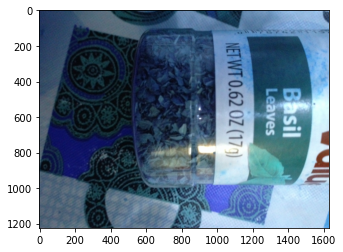

In [54]:
test_img_path = "/root/QianZe/VizWiz-VQA-tiny/test_rectify/VizWiz_train_00000000.jpg"
img_cv = cv2.imread(test_img_path)
img_np = np.array(img_cv)
img_np_1 = np.rot90(img_np, 3) # counter-clockwise k times

result = ocr.ocr(img_np_1, cls=True)
tmp_conf = 0
for box in result:
    _, text, drt = box
    tmp_conf += text[1]
print(result)
print(len(result))
print(tmp_conf)
plt.imshow(img_np_1)
plt.show()